# Toy model -- Double peak distribution
This notebook describes the analysis done for this simple model described by:
$$
p(x; \mu, \sigma^2) = \frac{1}{2}\left[\mathcal{N}(\mu,\sigma^2) + \mathcal{N}(-\mu,\sigma^2)\right].
$$

For this work, we set $\mu = 1$ and $\sigma^2 = 1/16$.

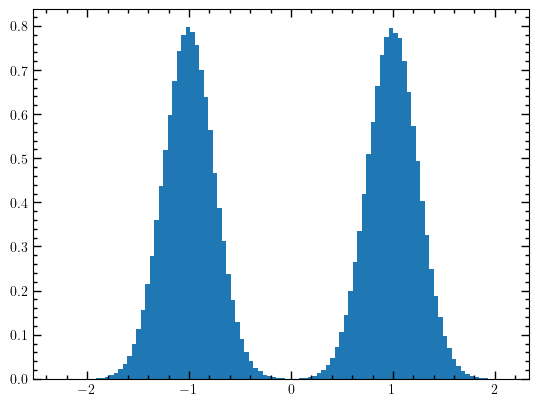

In [8]:
from utils import *

mu = 1; sigma = 0.25

samples = np.loadtxt("../data/double_peak_samples_1M.dat")
plt.hist(samples,bins=100,density=True)
plt.show()

# Variance Expanding diffusion

## Noise in the forward process

In [9]:
exact_m = np.array([
	sigma**2 + mu**2,
	3 * sigma**4 + 6 * sigma**2 * mu**2 + mu**4, 
	15 * sigma**6 + 45 * sigma**4 * mu**2 + 15*sigma**2 * mu**4 + mu**6,
	105 * sigma**8 + 420 * sigma**6 * mu**2 + 210 * sigma **4 * mu**4 + 28 * sigma**2 * mu**6 + mu**8
	])

exact_c = np.array([sigma**2 + mu**2, -2*mu**4, 16 * mu**6, -272 * mu**8])

max_order = len(exact_c) * 2

In [10]:
# Load data for noise in forward process by size of the dataset
size_labels = ['100K', '1M', '10M']

cumulants_by_size_filenames = ['../data/double_peak_cumulants_' + n + '.dat' for n in size_labels]
moments_by_size_filenames = ['../data/double_peak_moments_' + n + '.dat' for n in size_labels]

cumulants_by_size = []; moments_by_size = []

for mfile, cfile in zip(moments_by_size_filenames, cumulants_by_size_filenames):
    cumulants_by_size.append(
		np.loadtxt(cfile, delimiter=",").T
	)
    moments_by_size.append(
		np.loadtxt(mfile, delimiter=",").T
	)

# Concatenate and keep only even order cumulants. Odd order cumulants are vanishing.
cumulants_by_size = np.stack(cumulants_by_size, axis=0)[:, 1::2]
moments_by_size = np.stack(moments_by_size, axis=0)[:, 1::2]

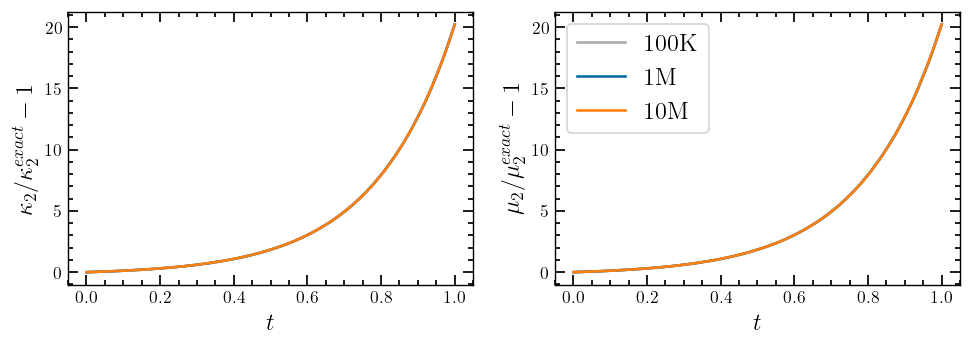

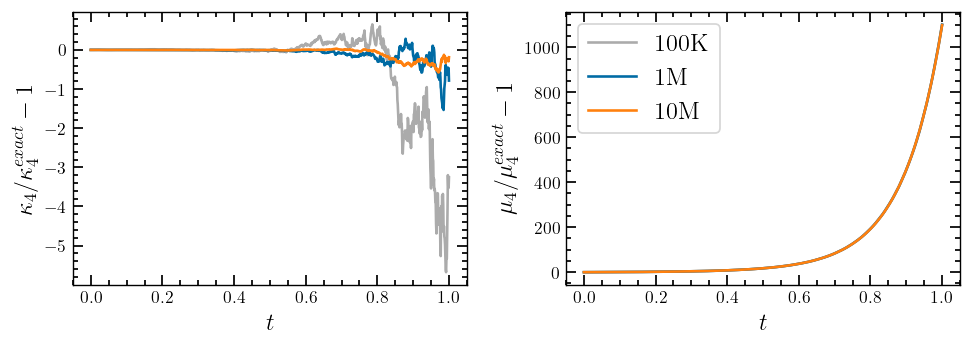

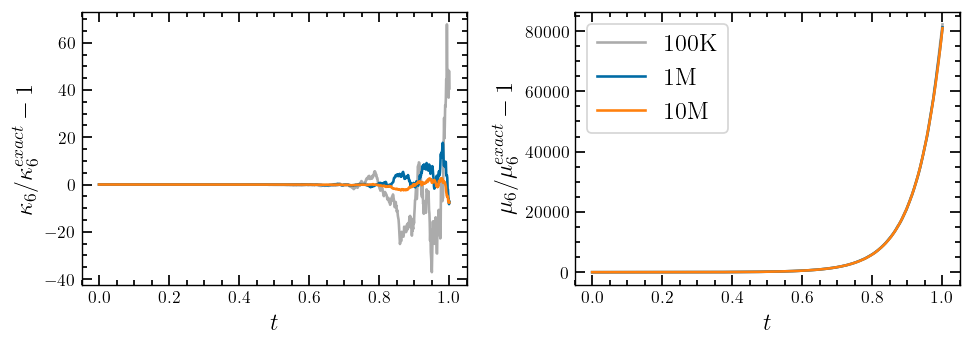

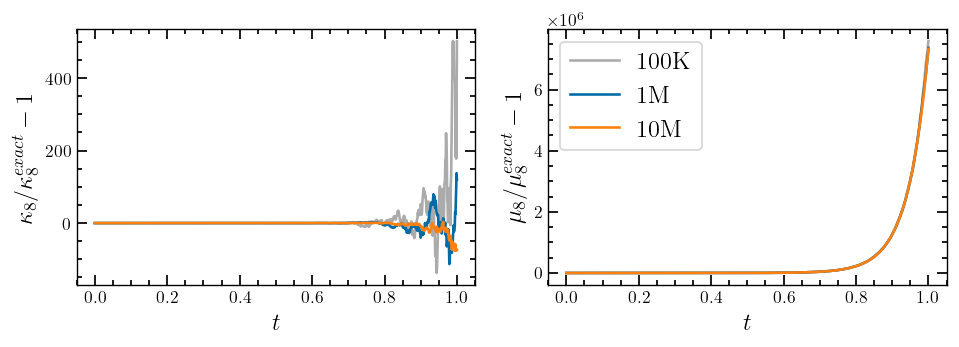

In [11]:
colors = ["#ababab", "#006ba4", "#ff800e"]
stat_c = cumulants_by_size[..., ::10]/exact_c[None, :, None] - 1
stat_m = moments_by_size[..., ::10]/exact_m[None, :, None] - 1
t= np.linspace(0, 1., stat_c.shape[-1])

for j in range(4):
	fig, ax = plt.subplots(1, 2, dpi=125, figsize=(8,3))
	for i, (c, m) in enumerate(zip(stat_c, stat_m)):
		ax[0].plot(t, c[j], label=size_labels[i], color=colors[i])
		ax[0].set_ylabel(f'$\\kappa_{(j+1) * 2}/\\kappa_{(j+1) * 2}^{{exact}} - 1$')
		ax[0].set_xlabel("$t$")

		ax[1].plot(t, m[j], label=size_labels[i], color=colors[i])
		ax[1].set_ylabel(f'$\\mu_{(j+1) * 2}/\\mu_{(j+1) * 2}^{{exact}} - 1$')
		ax[1].set_xlabel("$t$")

	plt.legend()
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'figures/cumulant{2 * (j + 1)}_fw_by_size.pdf')

## Backward process - VE

In [14]:
cumulants_bw.shape

(8, 1001)

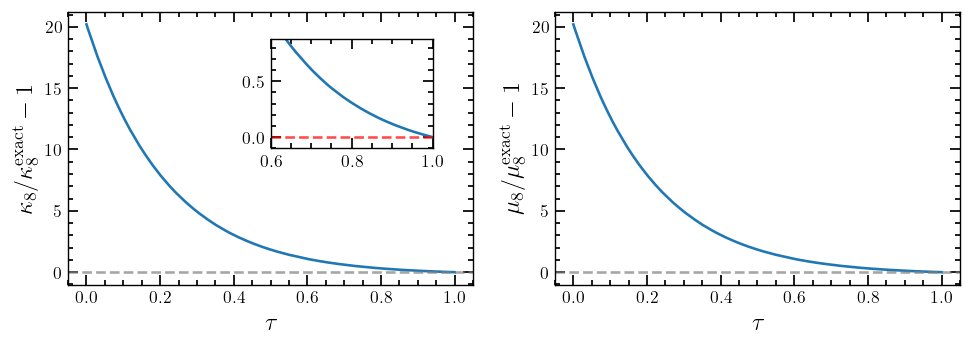

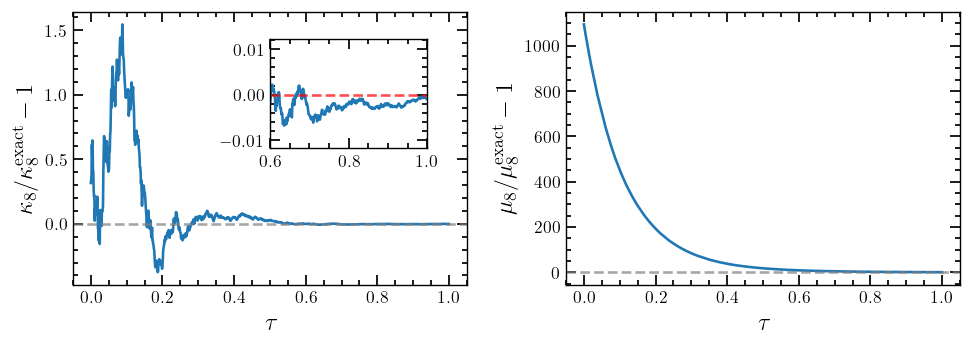

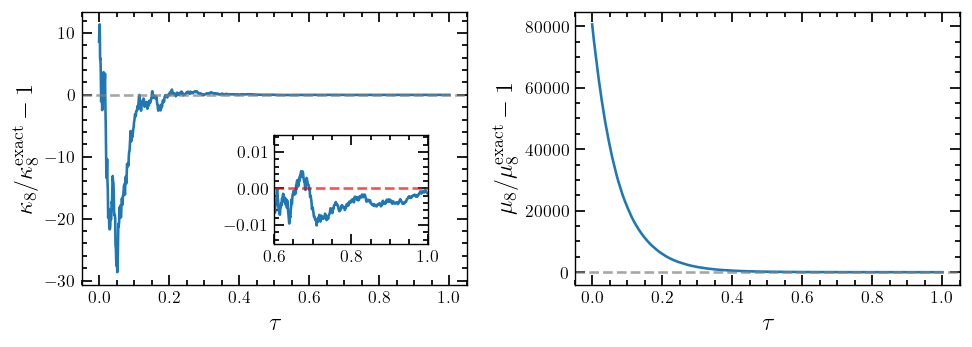

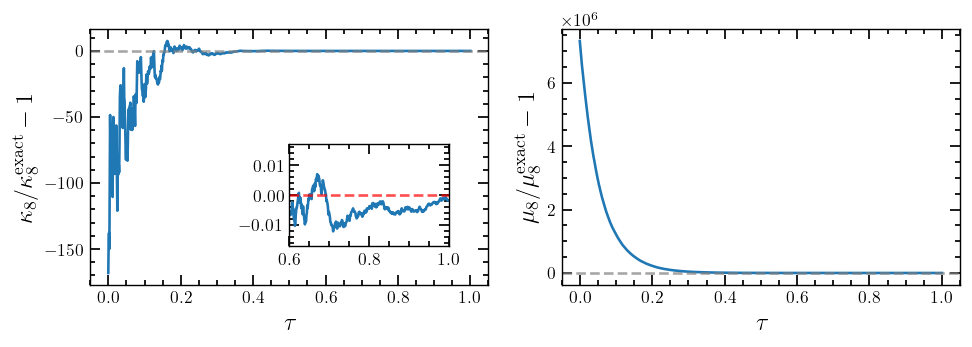

In [20]:
cumulants_bw = np.loadtxt("../data/bw_double_peak_cumulants_1M.dat", delimiter=",").T
moments_bw = np.loadtxt("../data/bw_double_peak_moments_1M.dat", delimiter=",").T

stat_c = cumulants_bw[1::2]/exact_c[:, None] - 1
stat_m = moments_bw[1::2]/exact_m[:, None] - 1
t= np.linspace(0, 1., stat_c.shape[-1])

subset_mask = (t > 0.6) & (t <= 1.)

y0 = [0.5, 0.5, 0.15, 0.15]
x0 = [0.5, 0.5, 0.5, 0.5]
off_low = [-0.1, -0.005, -.005, -.005]
off_high = [-0.2, 0.01, .01, .01]

for i, (c, m) in enumerate(zip(stat_c, stat_m)):
	fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))
	
	ax_[0].plot(t, c); ax_[1].plot(t, m)
	ax_[0].set_ylabel(f'$\\kappa_{(j+1) * 2}/\\kappa_{(j+1) * 2}^{{\\mathrm{{exact}}}} - 1$')
	ax_[1].set_ylabel(f'$\\mu_{(j+1) * 2}/\\mu_{(j+1) * 2}^{{\\mathrm{{exact}}}} - 1$')
 
	for ax in ax_.ravel():
		ax.axhline(0., ls='--', alpha=0.7, c='gray')
		ax.set_xlabel("$\\tau$")

	
	# Adding the inset
	inset_ax = ax_[0].inset_axes([x0[i], y0[i], 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(t[subset_mask], c[subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + off_low[i], max(c[subset_mask]) + off_high[i])

	plt.tight_layout()